In [14]:
%matplotlib notebook

In [15]:
from hxrsnd import maximize_lorentz
print(maximize_lorentz.__doc__)


    Maximize a signal with a Lorentzian relationship to a motor

    The following plan does a linear step scan through the parameter space
    while collecting information to create a Lorentzian model. After the scan
    has completed, the created model will be queried to find the estimated
    motor position that will yield the absolute maximum of the Lorentz equation

    Parameters
    ----------
    detector : obj
        The object to be read during the plan

    motor : obj
        The object to be moved via the plan.

    read_field : str
        Field of detector to maximize

    nsteps : int, optional
        The step size used by the initial linear scan to create the Lorentzian
        model. A smaller step size will create a more accurate model, while a
        larger step size will increase the speed of the entire operation.

    bounds : tuple, optional
        The lower and higher limit of the search space. If no value is given
        the :attr:`.limits` property of th

In [16]:
from hxrsnd.tests import crystal, Diode
print(Diode.__doc__)


    Simulated Diode

    Evaluate a point on a Lorentz function based on the value of a motor

    By default, the amplitude and sigma values will create a max signal of 1.0,
    representing a normalized diode signal

    Parameters
    ----------
    name : str

    motor : obj

    motor_field : str
        Name of field to use as independent variable

    center : float
        Center position of Lorentz

    sigma : float, optional
        Width of distribution

    amplitude : float, optional
        Height of distribution

    noise_multiplier : float, optional
        Multipler for uniform noise of the diode. If left as None, no noise will
        be applied
    


In [26]:
#Configure RunEngine
from bluesky.run_engine import RunEngine
from bluesky.plans      import run_wrapper
from bluesky.callbacks  import LivePlot
from bluesky.utils      import install_nb_kicker
RE = RunEngine()
install_nb_kicker()

#Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [47]:
import math

#Modify the Lorentz we are trying to maximize
actual_center      = 10.0
distribution_sigma = 2.0      #FWHM of Lorentz = 2 * sigma
distribution_amp   = distribution_sigma/1*math.pi  #Distribution maximum will be pi*amplitude / sigma
noise_multiplier   = 0.05    #Uniform noise

#Create simulated Diode readout
diode = Diode('intensity', crystal, 'angle', actual_center,
               sigma=distribution_sigma, amplitude=distribution_amp,
               noise_multiplier=noise_multiplier)

In [60]:
#Create plans to maximize the Lorentz
bounds  = (9., 11.)
nsteps  = 10
average = 50
initial_guess = None #Guess either the center, amplitude or sigma of the Lorentz
plan = run_wrapper(maximize_lorentz(diode, crystal, 'intensity',
                                    nsteps=nsteps, bounds=bounds,
                                    average=average,
                                    position_field='angle',
                                    initial_guess=initial_guess))

<IPython.core.display.Javascript object>


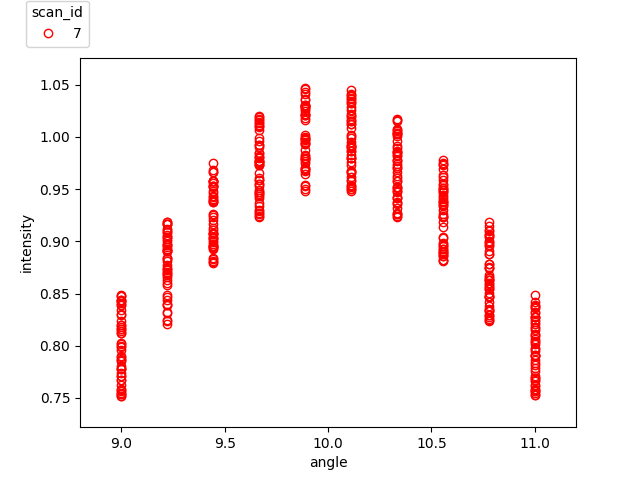

In [61]:
#Create Plot of Simulated Data
lp = LivePlot('intensity', 'angle', marker='o', markerfacecolor='None', markeredgecolor='r', linestyle='None')

In [62]:
#Run the plan
RE(plan, lp)

2017-09-14 17:13:16,132 Travelling to maximum of Lorentz at 10.042003544766665


['adfc3aff-d13b-4a5f-a813-752910d47118']

In [63]:
#Summarize success of plan
print("Final crystal position is {}, the actual center of the distribution "
      "is at {}".format(crystal.read()['angle']['value'], actual_center))
print("This leaves the diode readout at {}"
      "".format(diode.read()['intensity']['value']))

Final crystal position is 10.042003544766665, the actual center of the distribution is at 10.0
This leaves the diode readout at 1.0271184953221402
